In [11]:
import numpy as np
import scipy.special as ss
import matplotlib.pyplot as pl
%matplotlib inline

class neuralNetworks:

    def __init__(self, inputNodes, hiddenNodes, outputNodes, learningRate):
        self.inodes = inputNodes
        self.hnodes = hiddenNodes
        self.onodes = outputNodes
        
        self.lr = learningRate

        self.wih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        # create the sigmoid activation/squashing function using the lambda notation.
        self.activation_function = lambda x: ss.expit(x)

        self.scale_image = lambda array:  (np.asfarray(array[1:]) / 255.0 * 0.99) + 0.01

        pass

    def train(self, input_list, target_list):
        inputs = np.array(input_list, ndmin=2).T
        targets = np.array(target_list, ndmin=2).T
        
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)

        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)

        # Pythons magic matrix maths!
        output_errors = targets - final_outputs

        # Propogate the error back accoss contribuiting nodes (by their relative wieghts)
        hidden_errors = np.dot(self.who.T, output_errors)

        self.who += self.lr * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
        self.wih += self.lr * np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
        pass 

    def query(self, inputs_list):
        inputs = np.array(inputs_list, ndmin=2).T
        
        # the matrix dot product i.e. the result of applying the input values 
        # accross the wieghted connections into the hidden nodes.
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        

        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)

        return final_outputs

Lets create a small neural network and train it using a small MNist training data set.

In [12]:
i_nodes, h_nodes, o_nodes, l_rate = 784, 100, 10, 0.3 
nn = neuralNetworks(i_nodes, h_nodes, o_nodes, l_rate)

train_file = open("mnist_data/mnist_train_100.csv.txt")
train_list = train_file.readlines()
train_file.close()

for records in train_list:
    all_values = records.split(",")
    # scale the inputs from 0-255 to (+ 1.0) to (- 0.99)
    scaled_inputs = nn.scale_image(all_values)
    targets = np.zeros(o_nodes) + 0.01
    targets[int(all_values[0])] = 0.99
    nn.train(scaled_inputs, targets)
    pass


Test the network against the training data.

In [ ]:
mnist_file = open("mnist_data/mnist_test_10.csv.txt")
data_list = mnist_file.readlines()
mnist_file.close()

test_data = data_list[0].split(",")
image_array = nn.scale_image(test_data)

nn.query(image_array)





Plot an image from the data_list.

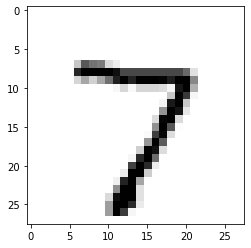

In [18]:
# Render image from data row
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

#all_values = test_data[0].split(",")
image_array = np.asfarray(test_data[1:]).reshape((28,28))
pl.imshow(image_array, cmap='Greys', interpolation='none')